<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session6/EVA4S6_CODE4_L1%2BL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([ 
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 26

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),   
            nn.Dropout(0.05)
       ) # output_size = 26

      #  self.convblock3 = nn.Sequential(
      #       nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(12),
      #       nn.Dropout(0.05)
      #  ) #output size = 22
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 13
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #output = 13

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 11

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #out = 11

       self.pool2 = nn.MaxPool2d((2,2)) #out = 5
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.1)
       ) #out = 5

      #  self.convblock71 = nn.Sequential(
      #       nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       #OUTPUT BLOCK

      #  self.convblock8 = nn.Sequential(
      #       nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

       self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.Linear(20,out_features=10)
        )

     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       #x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       #x = self.convblock71(x)
       #x = self.convblock8(x)
       x = self.gap(x)
       x = self.convblock9(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 26, 26]           1,512
       BatchNorm2d-6           [-1, 14, 26, 26]              28
              ReLU-7           [-1, 14, 26, 26]               0
           Dropout-8           [-1, 14, 26, 26]               0
         MaxPool2d-9           [-1, 14, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             140
      BatchNorm2d-11           [-1, 10, 13, 13]              20
             ReLU-12           [-1, 10, 13, 13]               0
          Dropout-13           [-1, 10, 13, 13]               0
           Conv2d-14           [-1

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    #L1
    #l1_crit = nn.L1Loss(reduction='sum')
    #L1_reg = torch.tensor(0., requires_grad=True)

    reg_loss = 0
    #for param in model.parameters():
    #     reg_loss += l1_crit(param)

    for param in model.parameters():
         reg_loss += torch.sum(abs(param))

    #print('Regloss', reg_loss)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    factor = 0.00005
    loss += factor * reg_loss   
        

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=11, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    print('')    

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08875769376754761 Batch_id=937 Accuracy=94.42: 100%|██████████| 938/938 [00:21<00:00, 43.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9811/10000 (98.11%)


EPOCH: 1


Loss=0.21125617623329163 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:21<00:00, 43.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)


EPOCH: 2


Loss=0.06512309610843658 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:21<00:00, 57.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9878/10000 (98.78%)


EPOCH: 3


Loss=0.06776265799999237 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:20<00:00, 44.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9856/10000 (98.56%)


EPOCH: 4


Loss=0.06449317932128906 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:21<00:00, 42.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9781/10000 (97.81%)


EPOCH: 5


Loss=0.13968788087368011 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:21<00:00, 43.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9844/10000 (98.44%)


EPOCH: 6


Loss=0.08370068669319153 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:21<00:00, 43.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9890/10000 (98.90%)


EPOCH: 7


Loss=0.12229963392019272 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:22<00:00, 42.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9873/10000 (98.73%)


EPOCH: 8


Loss=0.15021048486232758 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:21<00:00, 43.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9834/10000 (98.34%)


EPOCH: 9


Loss=0.11196711659431458 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:21<00:00, 42.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9893/10000 (98.93%)


EPOCH: 10


Loss=0.05980558320879936 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:21<00:00, 42.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9908/10000 (99.08%)


EPOCH: 11


Loss=0.0571049265563488 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:21<00:00, 48.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)


EPOCH: 12


Loss=0.0526001937687397 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:22<00:00, 41.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9937/10000 (99.37%)


EPOCH: 13


Loss=0.049392204731702805 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:21<00:00, 43.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)


EPOCH: 14


Loss=0.05915806442499161 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:22<00:00, 42.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9949/10000 (99.49%)


EPOCH: 15


Loss=0.06326081603765488 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:21<00:00, 43.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)


EPOCH: 16


Loss=0.048454221338033676 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:21<00:00, 42.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9945/10000 (99.45%)


EPOCH: 17


Loss=0.06904879957437515 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:21<00:00, 43.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)


EPOCH: 18


Loss=0.0862063318490982 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:21<00:00, 42.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)


EPOCH: 19


Loss=0.04135465994477272 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:21<00:00, 42.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)


EPOCH: 20


Loss=0.07360243797302246 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:21<00:00, 43.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)


EPOCH: 21


Loss=0.23842525482177734 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:22<00:00, 42.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)


EPOCH: 22


Loss=0.05065791681408882 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:21<00:00, 42.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)


EPOCH: 23


Loss=0.044901445508003235 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:21<00:00, 43.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)


EPOCH: 24


Loss=0.21848183870315552 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:22<00:00, 41.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)


EPOCH: 25


Loss=0.09334376454353333 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:22<00:00, 41.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)


EPOCH: 26


Loss=0.14636583626270294 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:21<00:00, 43.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)


EPOCH: 27


Loss=0.04378332197666168 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:21<00:00, 48.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)


EPOCH: 28


Loss=0.07232781499624252 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:22<00:00, 42.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)


EPOCH: 29


Loss=0.04419464245438576 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:21<00:00, 42.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)


EPOCH: 30


Loss=0.05277373641729355 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:21<00:00, 43.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)


EPOCH: 31


Loss=0.037922825664281845 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:22<00:00, 42.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)


EPOCH: 32


Loss=0.051153186708688736 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:22<00:00, 42.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)


EPOCH: 33


Loss=0.07823482155799866 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:22<00:00, 42.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)


EPOCH: 34


Loss=0.08228978514671326 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:22<00:00, 42.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)


EPOCH: 35


Loss=0.17456279695034027 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:21<00:00, 42.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)


EPOCH: 36


Loss=0.04413120076060295 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:22<00:00, 42.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)


EPOCH: 37


Loss=0.03904843330383301 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:22<00:00, 41.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)


EPOCH: 38


Loss=0.048203255981206894 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:22<00:00, 41.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)


EPOCH: 39


Loss=0.042124006897211075 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:22<00:00, 41.88it/s]



Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)




Text(0.5, 1.0, 'Test Accuracy')

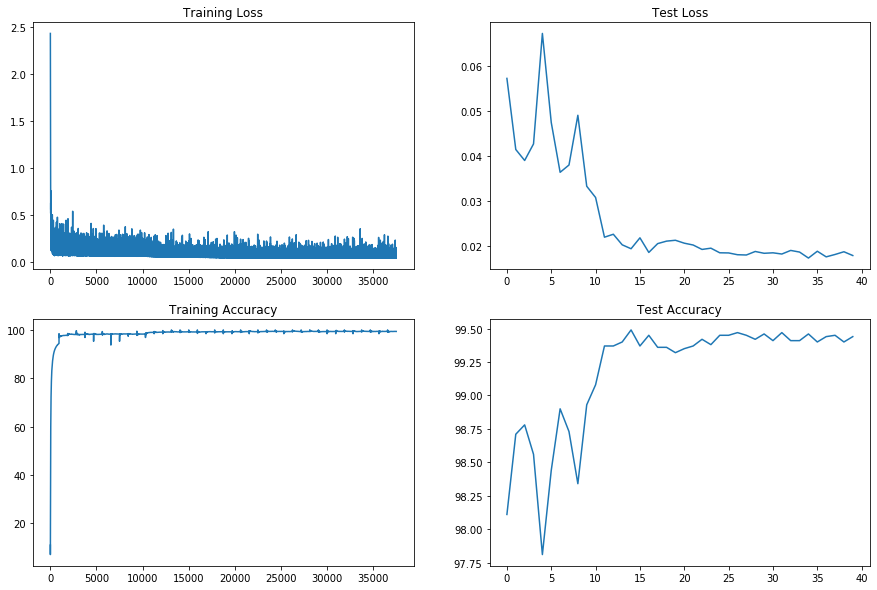

In [0]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
test_acc

[98.11,
 98.71,
 98.78,
 98.56,
 97.81,
 98.44,
 98.9,
 98.73,
 98.34,
 98.93,
 99.08,
 99.37,
 99.37,
 99.4,
 99.49,
 99.37,
 99.45,
 99.36,
 99.36,
 99.32,
 99.35,
 99.37,
 99.42,
 99.38,
 99.45,
 99.45,
 99.47,
 99.45,
 99.42,
 99.46,
 99.41,
 99.47,
 99.41,
 99.41,
 99.46,
 99.4,
 99.44,
 99.45,
 99.4,
 99.44]

In [0]:
test_losses

[0.05732102632522583,
 0.041443751978874205,
 0.03899158053398132,
 0.04268972117900848,
 0.06736578135490418,
 0.04747112545967102,
 0.036349484848976134,
 0.03798138451576233,
 0.049087152218818667,
 0.03323505120277405,
 0.03072198164463043,
 0.0218588506937027,
 0.022514274168014527,
 0.02015463593006134,
 0.019280084347724914,
 0.021717540836334228,
 0.01845328176021576,
 0.020425528216362,
 0.020977897882461547,
 0.02117165584564209,
 0.020521101450920103,
 0.020111455869674683,
 0.019124975633621217,
 0.01940537543296814,
 0.018374575567245484,
 0.018342750334739685,
 0.017942811799049378,
 0.017880751514434814,
 0.018669797587394715,
 0.018264486479759215,
 0.018369687390327454,
 0.01809851996898651,
 0.018901772117614745,
 0.018535819554328918,
 0.01719788603782654,
 0.01872177782058716,
 0.01746646144390106,
 0.017998728489875795,
 0.018606094884872436,
 0.01776366274356842]